In [1]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
import os, sys
from copy import deepcopy            # To completely copy lists and not references
from pandas import DataFrame, Series  # for convenience
import cv2                           # OpenCV for video and image procedures
                                   # generating a folder or deleting files, etc.
import multiprocessing as mp         # This is for preventing large videos to take too much internal memory
import shutil                        # Deleting folders
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-2*I/A)+vmin

def analyseTDMS(file):
    # Print properties and channels of TDMS file
    tdms_file = TdmsFile(file)
    print('Properties (Root):')
    for name, value in tdms_file.object().properties.items():
        print(2*' ' + "{0}: {1}".format(name, value))
    for group in tdms_file.groups():
        print('\'' + group + '\'')
        print(2*' ' + 'Properties (' + '\'' + group + '\'' ')')
        for name, value in tdms_file.object(group).properties.items():
            print('')
        for channel in tdms_file.group_channels(group):
            print(2*' ' + channel.channel)

In [15]:
filenumber=9
folder = "/Users/alex/Documents/Measurements/200825 - Multiple"
loadvideofile = False
if loadvideofile == False:
    dt = 0.05
    videosize = 512

pxtomum=0.0533#0.0719e-6
maxpower = 4

R = 2.19e-6/2
T = 273.15+22
kB = 1.38064852e-23
eta=2.414e-5*10**(247.8/(T-140))
D_0 = kB*T/(6*np.pi*eta*R)
D_0 = 3.85e-14

amplitude = 1
start_time = time.time()   
if filenumber < 10:
        tdms_file = TdmsFile(folder+"/Test_00"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_00"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_00"+str(filenumber)+"_module.tdms")
else:
    if filenumber < 100:
        tdms_file = TdmsFile(folder+"/Test_0"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_0"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_0"+str(filenumber)+"_module.tdms")
    else:
        filetdms_file = TdmsFile(folder+"/Test_"+str(filenumber)+"_module.tdms")
        #analyseTDMS(folder+"/Test_"+str(number)+"_module.tdms")
        if loadvideofile == True:
            tdms_file = loadTDMS_Video(folder+"/Test_"+str(filenumber)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

Xc = tdms_file['Data']['Xc']
Yc = tdms_file['Data']['Yc']
velocitytheo = tdms_file['Data']['Velocity']
angletheo = tdms_file['Data']['Angle']
xolaser = tdms_file['Data']['Xh']
yolaser = tdms_file['Data']['Yh']
Nfound = tdms_file['Data']['N']
Nlaser = tdms_file['Data']['NLaser']
delaywave = tdms_file['Data']['Delays']
iterationtime = tdms_file['Data']['Iterationtime']
programtime = tdms_file['Data']['Programtime']
phase = tdms_file['Data']['Phase']
p = tdms_file.object().properties
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
boundaryradius = p['Boundary']
offset = p['Offset']
sigmavelo = p['Sigmavelo']
vmin = p['Vmin']
vmax = p['Vmax']
videosize = p['Xsize']
vfactor = vmax - vmin
firstlength = len(Nfound)
maxlength = 0
for i in range(firstlength):
    if phase[i] == 0: maxlength += 1
if loadvideofile == True:
    dt = kinetic_cycle
    videosize = dimx
timewave=np.linspace(0,maxlength*dt,maxlength)
dtprogram = 13.6e-3                             #time of the program (tracking + calculation) [s]
dtsendtoadwin = 1e-3                            #time to send signal from PC to Adwin [s]
dttransferfromcamtocom = 1e-3                   #time to send from cam to PC (unknown) [s]
dtframetransfer = videosize * 1.9176e-6         #time for frametransfer [s]
dtreadout = (1032/(27e6) + 1.9176e-6)*videosize #time to readout the cam [s]

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

--- 12.44 seconds ---
size of the video =  800
length of the movie =  10000


/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)


 
Trajectory length
[9999. 9999. 9999. 9999. 9999.]


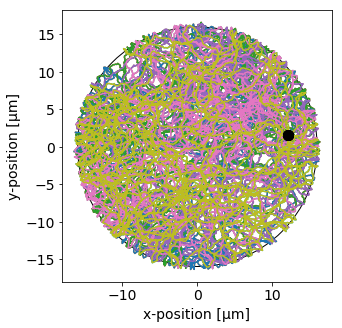

In [41]:
number = 5#int(stats.mode(Nfound))
maxnumber = int(max(Nfound))
particles = np.zeros((maxlength,number,8))
lastone = np.zeros((number,2))
pre = np.zeros((maxlength,maxnumber,8))
count = 0
test = np.zeros((int(Nfound[0]),2))
for i in range(int(Nfound[0])):             #Sort the particles in the first frame according to there 
    test[i,0] = i                           #distance to the center, particles outside the boundary are not important
    test[i,1] = np.sqrt(pow(Xc[i]-videosize/2,2)+pow(Yc[i]-videosize/2,2))
check = sorted(test, key=lambda test: test[1])
order = np.zeros(int(Nfound[0]))
for i in range(int(Nfound[0])):
    test2 = check[i]
    order[i] = test2[0]  
for j in range(int(Nfound[0])):
    pre[0,j,0] = Xc[int(order[j])]
    pre[0,j,1] = Yc[int(order[j])]
    pre[0,j,2] = velocitytheo[int(order[j])]
    pre[0,j,3] = angletheo[int(order[j])]
    count += 1

for i in range(1,maxlength):               #Write all position in a first wave
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        pre[i,j,2] = velocitytheo[count]
        pre[i,j,3] = angletheo[count]
        count += 1
count = 0
for i in range(maxlength):
    for j in range(int(Nlaser[i])):          #Also copy the laser position in a first wave
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        count += 1
        
sumup = Nfound[0]                         #sumup - if the first frames are without a particle, they willbe cut off
if Nfound[0] != 0: starttraj = 0
particles[0,:,:] = pre[0,:number,:]
for i in range(1,maxlength):
    if sumup != 0:
        check = False; occupied = np.zeros(int(Nfound[i]))
        for p in range(2):                    #first check those particles which where found in the frame before
            if p == 0:
                if particles[i-1,j,0] != 0: check = True
            else:
                if particles[i-1,j,0] == 0: check = True          
            if check == True:
                for j in range(number):           
                    sumup += Nfound[i]
                    if particles[i-1,j,0] != 0:    #remember how long the particle is lost
                        lastone[j,0] = i-1
                        lastone[j,1] = 0
                    else: lastone[j,1] += 1
                    xpre = particles[int(lastone[j,0]),j,0]
                    ypre = particles[int(lastone[j,0]),j,1]
                    mindist = 50; minnum = 666
                    for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                        if occupied[k] == 0:
                            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                            if dist < mindist:
                                mindist = dist
                                minnum = k
                                #print('i = ',i,' - j = ',j,' - mindist = ',round(mindist,1),' - minnum = ',minnum)
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,:] = pre[i,minnum,:]
                        occupied[minnum] = 1
    else:
        if Nfound[i] != 0:
            starttraj = i
            sumup += Nfound[i]
            for j in range(int(Nfound[i])): particles[i,j,:] = pre[i,j,:]
    #print('i = ',i,' - Nfound = ',Nfound[i],' - x[i,0] = ',int(particles[i,0,0]))

for i in range(1,maxlength):
    for j in range(number):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan     
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
particles[:,:,4:6] = (particles[:,:,4:6]-videosize/2)*pxtomum
save = particles.copy()
cutlastpoints = False
trajlength = np.zeros(number)
for j in range(number):
    lastfound = 0; out = True
    for i in range(starttraj+1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                        #print('j = ',j,' - i = ',i,' - gap = ',count)
                        check = False
                    else: 
                        count +=1
                        #print('i = ',i,' count =',count)
                    if count == 100:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                #print('particle number = ',j,' - position = ',i,' gap length = ',count)
                if out == True:
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                        particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                        particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                    #print('AFTER')
                    #for k in range(0,count+1):
                    #    print('...... i = ',lastfound+k,' - x = ',round(particles[lastfound+k,j,0],1))
                    #print('----------')
            if i == firstlength-1: 
                trajlength[j] = i
particlessave = particles.copy()
if starttraj != 0:
    maxlength = int(maxlength-starttraj)
    particles = np.zeros((maxlength,number,6))
    particles = particlessave[starttraj:,:,:]
if cutlastpoints == True:
    particlessave = particles.copy()
    delete = firstlength - trajlength[0]
    maxlength = int(maxlength-delete)
    particles = np.zeros((maxlength,number,6))
    particles = particlessave[:maxlength,:,:]
timewave=np.linspace(0,maxlength*dt,maxlength)

print(' ')
print('Trajectory length')                  
print(trajlength)


fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(number):
    ax.scatter(particles[starttraj,0,0],particles[starttraj,0,1],color='k',s = 100,zorder=3)
    ax.plot(particles[:,i,0],particles[:,i,1],zorder=2)
    ax.plot(save[:,i,0],save[:,i,1],zorder=1)
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
plt.show()

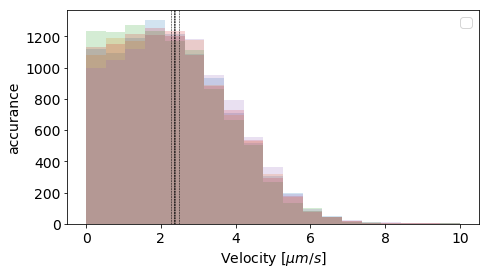

velocity particle 1 : 2.37  µm/s
velocity particle 2 : 2.36  µm/s
velocity particle 3 : 2.26  µm/s
velocity particle 4 : 2.34  µm/s
velocity particle 5 : 2.47  µm/s


In [42]:
directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,number));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,number))
velocity2 = np.zeros((maxlength,number,2))
distancetocenter = np.zeros((maxlength,number))

for j in range(number):
    directionvector[:,0] = np.cos(particles[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particles[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        distancetocenter[i,j] = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        movingvector[i,0] = particles[i,j,0]-particles[i-1,j,0]
        movingvector[i,1] = particles[i,j,1]-particles[i-1,j,1]
        stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocity[i,j] = stepsize[i]/dt
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        if distancetocenter[i,j] < boundaryradius*pxtomum:
            velocity2[i,j,0] = velocity[i,j]
            velocity2[i,j,1] = velocitywithdiffusion[i,j]
for j in range(number):
    for i in range(maxlength):
        if velocity2[i,j,0] == 0: velocity2[i,j,:]=np.nan
        
wave = velocity2[:,:,0]
binwave=np.linspace(np.amin(wave[~np.isnan(wave)]),min(np.amax(wave[~np.isnan(wave)]),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(number):
    wave = velocity2[:,i,0]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
#plt.text(3,0,'mean step size 1: {:.2f} µm/s'.format(np.mean(velocity)),fontsize=12)
plt.legend()
plt.tight_layout() 
plt.savefig('Velocities'+str(filenumber)+'.pdf', format='pdf')
plt.show() 

for i in range(number): 
    wave = velocity2[:,i,0]    
    print('velocity particle',str(i+1),':',round(np.nanmean(wave),2),' µm/s')

In [43]:
distcheck = np.zeros((maxlength,number))
sigma = 2 * 100**2
for i in range(maxlength):
    for j in range(number):
        particles[i,j,7] = 0
        for k in range(number):
            if j != k:
                dx = particles[i,j,0]-particles[i,k,0]
                dy = particles[i,j,1]-particles[i,k,1]
                dist = np.sqrt(dx*dx+dy*dy)/pxtomum
                distcheck[i,j] = dist
                particles[i,j,7] += 2*np.exp(-dist*dist/sigma)
        particles[i,j,7] /= number
        if particles[i,j,7] > 1: particles[i,j,7] = 1

comlocation = np.zeros((maxlength,5))
for i in range(maxlength):
    if prod(particles[i,:,0]) != 0:
        comlocation[i,0] = np.nanmean(particles[i,:,0])
        comlocation[i,1] = np.nanmean(particles[i,:,1])
for i in range(maxlength):
    if comlocation[i,0] == 0:
        pre = i-1
        check = False; checknumber = i+1
        while check == False:
            if checknumber < maxlength:
                if comlocation[checknumber,0] != 0:
                    post = checknumber
                else:
                    checknumber += 1
            else:
                check = True
        comlocation[i,:] = (comlocation[pre,:] + comlocation[post,:])/2
        
for i in range(maxlength):
    for j in range(number):
        particles[i,j,6] = np.sqrt(pow(particles[i,j,0]-comlocation[i,0],2)+pow(particles[i,j,1]-comlocation[i,1],2))
    comlocation[i,2] = np.mean(particles[i,:,6])
    comlocation[i,3] = np.mean(particles[i,:,7])
    #comlocation[i,4] = np.mean(velocity[i,:])
    comlocation[i,4] = np.mean(particles[i,:,2])

meandisttocom = np.mean(comlocation[:,2])
meanintensity = np.mean(comlocation[:,3])
print('average distance to the CoM: ',meandisttocom)
print('average sensed intensity: ',meanintensity)

average distance to the CoM:  8.652600735386798
average sensed intensity:  0.30576005886080043


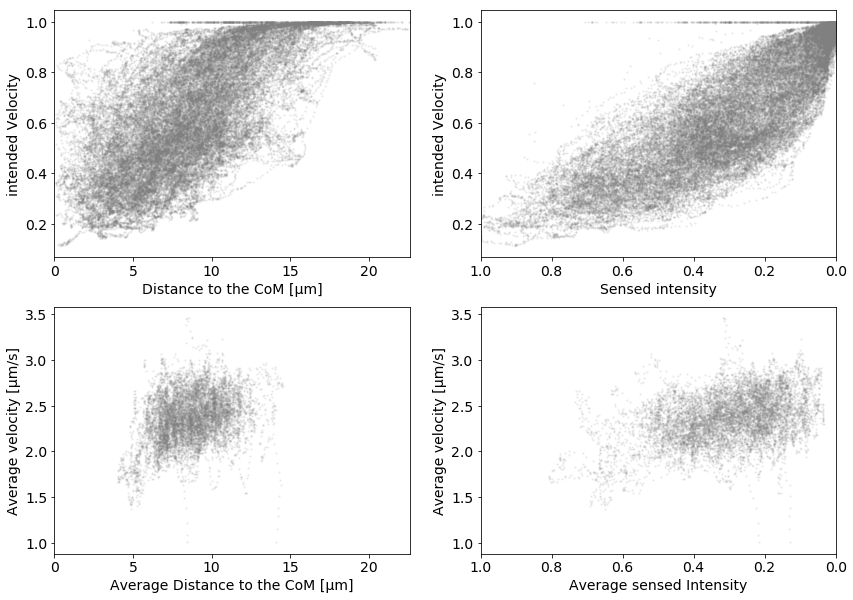

In [44]:
fig=plt.figure(1, figsize = (14,10) )
ax = plt.subplot(2,2,1)
for i in range(number):
    plt.scatter(particles[:,i,6],particles[:,i,2],s=2,c='grey',alpha=0.1)
plt.xlabel('Distance to the CoM [µm]')
plt.ylabel('intended Velocity')
plt.xlim([0,np.nanmax(particles[:,:,6])])
    
ax = plt.subplot(2,2,2)
for i in range(number):
    plt.scatter(particles[:,i,7],particles[:,i,2],s=2,c='grey',alpha=0.1)
plt.xlabel('Sensed intensity')
plt.ylabel('intended Velocity')
plt.xlim([1,0])

smoothvalue = 20
smoothit = np.zeros((maxlength,number+1))
for i in range(number): smoothit[:,i] = smooth(velocity[:,i],smoothvalue)
for i in range(maxlength): smoothit[i,-1] = mean(smoothit[i,:-1])

ax = plt.subplot(2,2,3)
#plt.scatter(comlocation[:,2],comlocation[:,4],s=2,c='grey',alpha=0.1)
plt.scatter(comlocation[:,2],smoothit[:,-1],s=2,c='grey',alpha=0.1)
plt.xlabel('Average Distance to the CoM [µm]')
plt.ylabel('Average velocity [µm/s]')
plt.xlim([0,np.amax(particles[:,:,6])])

ax = plt.subplot(2,2,4)
#plt.scatter(comlocation[:,3],comlocation[:,4],s=2,c='grey',alpha=0.1)
plt.scatter(comlocation[:,3],smoothit[:,-1],s=2,c='grey',alpha=0.1)
plt.xlabel('Average sensed Intensity')
plt.ylabel('Average velocity [µm/s]')
plt.xlim([1,0])
plt.savefig('Velocity vs CoM-intensity'+str(filenumber)+'.pdf', format='pdf')
plt.show()

#im = ax.scatter(x,y,c=v,linewidths=0.5)

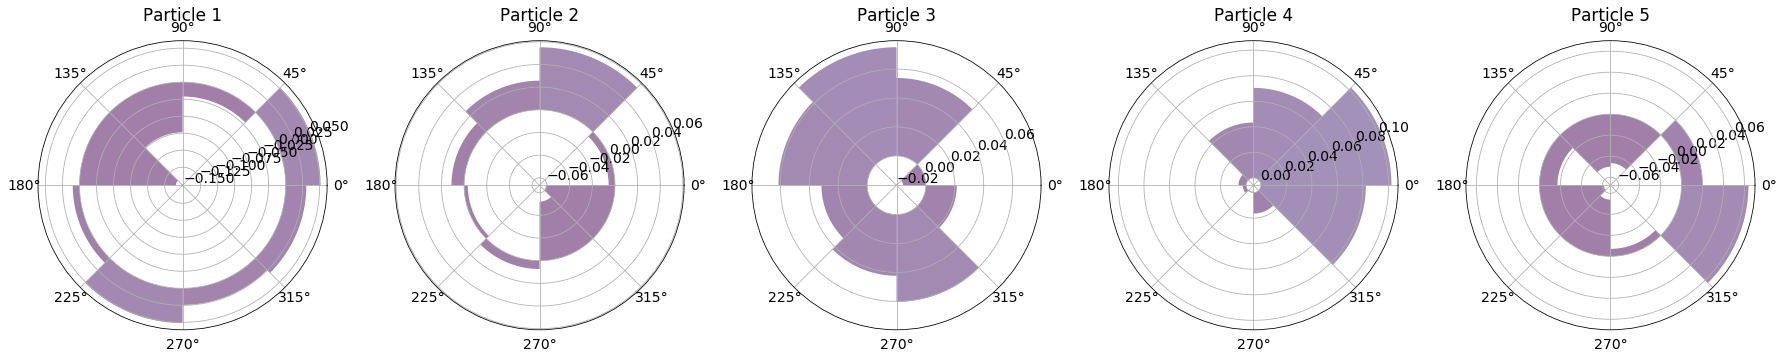

In [46]:
laserangle = np.zeros((maxlength,number));diffangle = np.zeros((maxlength,number))
moveangle = np.zeros((maxlength,number));diffmoveangle = np.zeros((maxlength,number))
delaylaserangle = 0   #in frames
delaydirection = 2    #in frames
angle = particles[:,:,3]
for j in range(number):
    for i in range(maxlength):  
        dx = particles[i,j,0]-particles[i,j,4]             #Calc the angle of the laser
        dy = particles[i,j,1]-particles[i,j,5]
        laserangle[i,j] = np.arctan(dy/dx)*180/np.pi
        #laserangle[i] = - laserangle[i]
        if laserangle[i,j] != laserangle[i,j]: laserangle[i,j] = 90
        if dx > 0:
            if dy < 0: laserangle[i,j] += 360
        else: laserangle[i,j] += 180
        if laserangle[i,j]>360: laserangle[i,j] -= 360
        if i >= delaylaserangle:                      #Calc difference between required laser angle and real angle
            diffangle[i,j] = particles[i-delaylaserangle,j,3] - laserangle[i,j]
            if abs(diffangle[i,j]) > 180:
                    if diffangle[i,j] > 0: diffangle[i,j] -= 360
                    else: diffangle[i] += 360
            if abs(diffangle[i,j]) > 40: diffangle[i,j] = 0
                #print('Error laser? : i = ',i)

fig=plt.figure(1, figsize = (5*number,5) )                
for k in range(number):
    distlaser = np.zeros(maxlength)
    parts = 8
    distangle = np.zeros((parts,4))     #0 - angle, 1 - distlaser, 2 - counts, 3 - velocity
    for i in range(parts): distangle[i,0] = (i+1)/parts * 360
    for i in range(maxlength-1):                        #Statistic over the laser offset (and the velocity in required direction) vs the required direction
        distlaser[i] = np.sqrt(pow(particles[i,k,4]-particles[i,k,0],2)+pow(particles[i,k,5]-particles[i,k,1],2))
        if abs(distlaser[i]-offset*pxtomum) > 1.5:
            #print('To high laser offset, t = ',round(i*dt,2),' s - dist = ',round(abs(distlaser[i]-offset),1),' µm')
            distlaser[i] = distlaser[i-1]
        if laserangle[i,0]<distangle[0,0]:
            distangle[0,1] += distlaser[i]
            distangle[0,2] += 1
            distangle[0,3] += velocity[i,k]
        else:
            for j in range(1,parts):
                if laserangle[i,0] > distangle[j-1,0] and laserangle[i,k] < distangle[j,0]:
                    distangle[j,1] += distlaser[i]
                    distangle[j,2] += 1
                    distangle[j,3] += velocity[i,k]
    distangle[:,1] /= distangle[:,2]
    distangle[:,3] /= distangle[:,2]
    timewave = np.linspace(0,maxlength*dt,maxlength,endpoint=False)

    theta = np.linspace(0, 2 * np.pi, parts, endpoint=False)
    radii = distangle[:,3] - np.mean(velocity[:,k])
    width = 2*np.pi / (parts)
    theta += width/2
    ax = plt.subplot('1'+str(number)+str(k+1), projection='polar')
    ax.set(aspect="equal",title='Particle '+str(k+1))
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r))
        bar.set_alpha(0.5)
plt.tight_layout() 
plt.savefig('Velocity angle'+str(filenumber)+'.pdf', format='pdf')
plt.show()

In [ ]:
for k in range(number):
    value = particles[:,k,2]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i,k]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i,k]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i,k]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i,k]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    for i in range(maxlength):
        for j in range(steps2):
            if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan

    maxvelocity = speedhisto[-1,1]
    print('maxvelocity = ',round(maxvelocity,2))

In [ ]:
x = particles[:,:,0]
y = particles[:,:,1]
factor = 1.1
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
gridsizevalue = 15
#fig, axs = plt.subplots(ncols=1, figsize=(8.5,7), sharex='all')
#fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)

fig=plt.figure(1, figsize = (8.5,7) ) 
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = plt.subplot(1,1,1)
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
#ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.axis('equal')
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(filenumber)+'.pdf', format='pdf')
#plt.savefig('Path of the particle colored'+str(filenumber)+'.svg', format='svg')
plt.show()